In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import griddata
cmap = 'plasma'

## 1. Define S(Qx, Qy) function

In [2]:
def f_ellipse_IQ(Qx, Qy, size, aspect, pl, az, background=0.0, contrast=1.0, flated=False):
    """
    2D scattering from a uniformly oriented ellipsoid, with:
    - Beam along z-axis
    - pl: angle from +y axis
    - az: angle in xz-plane from +x direction
    
    Parameters:
    - Qx, Qy: 2D arrays of scattering vector components (detector plane)
    - size: equatorial radius
    - aspect: polar / equatorial aspect ratio
    - pl: elevation from +y axis (radians)
    - az: azimuthal angle in xz-plane, az=0 is +x (radians)
    - background: flat background level
    - contrast: scattering length density contrast
    
    Returns:
    - I(q): 2D array of scattering intensity
    """
    Re = size
    Rp = size * aspect

    q = np.sqrt(Qx**2 + Qy**2)
    q_safe = np.where(q == 0, 1e-10, q)  # avoid divide-by-zero

    # Unit vector of q in detector plane (z = 0)
    q_hat = np.stack([Qx / q_safe, Qy / q_safe, np.zeros_like(Qx)], axis=-1)

    # Ellipsoid axis unit vector from (pl, az)
    u = np.array([
        np.sin(pl) * np.cos(az),  # x
        np.cos(pl),               # y
        np.sin(pl) * np.sin(az)   # z
    ])

    # Compute angle between q and ellipsoid axis
    print(q_hat.shape, u.shape)
    ax_index = 2-flated
    cos_alpha = np.clip(np.tensordot(q_hat, u, axes=([ax_index], [0])), -1.0, 1.0)
    alpha = np.arccos(cos_alpha)

    # Effective radius
    r = np.sqrt(Re**2 * np.sin(alpha)**2 + Rp**2 * np.cos(alpha)**2)

    # Form factor amplitude
    V = (4/3) * np.pi * Re**2 * Rp
    qr = q * r
    qr_safe = np.where(qr == 0, 1e-10, qr)

    F_q = contrast * (3 * (np.sin(qr_safe) - qr_safe * np.cos(qr_safe)) / qr_safe**3)

    # Scattering intensity (unit-normalized)
    I_q = F_q**2 + background
    return I_q

def f_gaussian_chain_IQ(Qx, Qy, Rg, gamma, contrast=1.0, background=0.0, pl=0.0, az=0.0):
    """
    2D scattering from a uniaxially affine-tensed Gaussian chain with orientation.

    Parameters:
    - Qx, Qy: 2D arrays of scattering vector components (same shape)
    - Rg: radius of gyration
    - gamma: magnitude of tensile strain
    - contrast: scattering length density contrast (intensity scales with contrast^2)
    - background: constant background intensity
    - pl: polar angle from +y axis (radians)
    - az: azimuthal angle in xz-plane from +x direction (radians)

    Returns:
    - I(Qx, Qy): 2D array of scattering intensity
    """
    # Stack q into shape (..., 3)
    qx_flat = Qx.ravel()
    qy_flat = Qy.ravel()
    qz_flat = np.zeros_like(qx_flat)
    qvecs = np.stack([qx_flat, qy_flat, qz_flat], axis=1)  # shape: (N, 3)

    # Define strain axis unit vector u using spherical angles (pl, az)
    u = np.array([
        np.sin(pl) * np.cos(az),  # x
        np.cos(pl),               # y
        np.sin(pl) * np.sin(az)   # z
    ])

    # Decompose q into parallel and perpendicular components to u
    q_dot_u = np.dot(qvecs, u)            # projection along u (shape: N,)
    q_parallel = np.outer(q_dot_u, u)     # shape: (N, 3)
    q_perp = qvecs - q_parallel           # shape: (N, 3)

    q_par2 = np.sum(q_parallel**2, axis=1)
    q_perp2 = np.sum(q_perp**2, axis=1)

    # Compute y from generalized Equation (14)
    y = (q_perp2 / gamma**2 + gamma * q_par2) * Rg**2

    # Avoid divide-by-zero
    y_safe = np.where(y == 0, 1e-10, y)

    # Compute intensity
    I = 2.0 * (np.exp(-y_safe) + y_safe - 1.0) / y_safe**2

    # Reshape back to 2D and apply contrast and background
    I_2d = contrast**2 * I.reshape(Qx.shape) + background
    return I_2d



visualize one instance

(100, 100, 3) (3,)


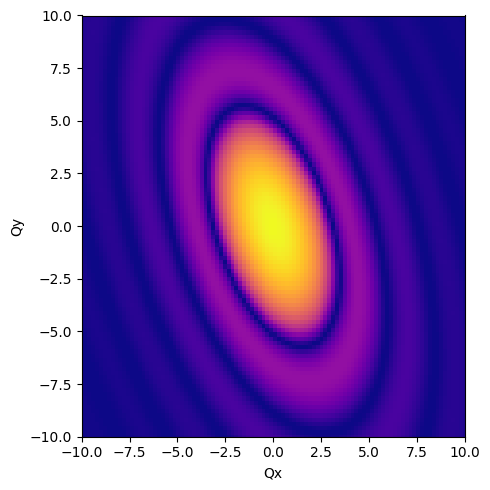

In [3]:
n_pixels = 100
q_list_x = np.linspace(-10, 10, n_pixels)
q_list_y = np.linspace(-10, 10, n_pixels)
qx, qy = np.meshgrid(q_list_x, q_list_y, indexing='ij')
qx_flat = qx.flatten()
qy_flat = qy.flatten()
n_pixels_total = qx_flat.shape[0]

## ellipsoid
# Parameters
size = 0.75  # equatorial radius (e.g., Å)
aspect = 2.0  # prolate ellipsoid
pl = np.radians(70)  # polar angle
az = np.radians(0)  # azimuthal angle
background = 0.001  # background level


## gaussian chain
# Parameters
Rg = 4  # equatorial radius (e.g., Å)
gamma = 1.5  # tensile strain
pl = np.radians(70)  # polar angle
az = np.radians(0)  # azimuthal angle
background = 0.001  # background level

# def f_IQ(qx, qy):
#     # wrap the gaussian chain function
#     return f_gaussian_chain_IQ(qx, qy, Rg, gamma, contrast=1.0, background=background, pl=pl, az=az)

def f_IQ(qx, qy):
    # wrap the ellipsoid function
    return f_ellipse_IQ(qx, qy, size, aspect, pl=pl, az=az, background=background)

# Compute intensity
p_2D = f_IQ(qx, qy)

# Plot
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log10(p_2D), cmap=cmap, vmax=0, vmin=-3)
# ax.contour(qx, qy, p_2D, colors='k', linewidths=1.5)
ax.set_xlabel('Qx')
ax.set_ylabel('Qy')

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])  # Set limits for the axes

plt.tight_layout()

def f_I_q(n_sample, p_qxy, seed =19810, qx_list = q_list_x, qy_list = q_list_y):
    """
    n_sample: total number of detector counts
    p_qxy: 2D array of scattering intensity
    seed: random seed for reproducibility
    qx_list: x-coordinates of the detector pixels
    qy_list: y-coordinates of the detector pixels
    
    output:
    I_q_grid: 2D array of sampled intensity (counts)
    delta_I_q_grid: 2D array of standard deviation of sampled intensity
    """
    
    np.random.seed(seed)
    bin_edges_x = np.append(qx_list - (qx_list[1] - qx_list[0]) / 2, qx_list[-1] + (qx_list[1] - qx_list[0]) / 2)
    bin_edges_y = np.append(qy_list - (qy_list[1] - qy_list[0]) / 2, qy_list[-1] + (qy_list[1] - qy_list[0]) / 2)
    qx, qy = np.meshgrid(q_list_x, q_list_y, indexing='ij')

    # flat the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid
    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges_x, bin_edges_y])
    
    # evaluate the std of sampled points in each grid
    I_q_grid_fillzero = np.where(I_q_grid == 0, 1, I_q_grid)
    delta_I_q_grid = np.sqrt(I_q_grid_fillzero)  # standard deviation of sampled points in each grid
    # delta_I_q_grid = np.sqrt(p_qxy/np.sum(p_qxy) * n_sample)

    return I_q_grid, delta_I_q_grid

## 3. Define orientational basis

In [4]:
## Identification of principal axis 
def f_pl_obs(qx_obs, qy_obs, I_obs):
    qxqx = np.sum(I_obs * qx_obs * qx_obs)
    qxqy = np.sum(I_obs * qx_obs * qy_obs)
    qyqy = np.sum(I_obs * qy_obs * qy_obs)
    R = [[qxqx, qxqy], [qxqy, qyqy]]
    eigenvalues, eigenvectors = np.linalg.eig(R)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
    pl_eigen = np.arctan2(principal_axis[1], principal_axis[0])
    return pl_eigen

def f_C(theta, n, theta_0=0, bg=True):
    """
    Construct a symmetric cosine basis matrix evaluated at given angles.

    Parameters:
    - theta: array-like, angles where basis is evaluated (in radians)
    - n: number of non-constant cosine modes (n > 0)
    - theta_0: alignment angle for symmetry shift
    - bg: if True, include constant (isotropic) term in first column

    Returns:
    - C: (len(theta), n+1) array if bg=True, else (len(theta), n) array
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    n_list = 2 * (np.arange(n) + 1)  # modes: 2, 4, ..., 2n

    C_cos = np.cos(np.outer(theta_shift, n_list))  # shape (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))  # constant term
        C = np.concatenate([C_0, C_cos], axis=1)  # (M, n+1)
    else:
        C = C_cos  # (M, n)

    return C

def f_CS(theta, n, theta_0=0, bg=True):
    """
    Construct a real-valued Fourier basis with symmetric cosine and sine terms.

    Parameters:
    - theta: array-like, input angles in radians
    - n: number of cosine/sine harmonics (positive integers)
    - theta_0: alignment angle (shifts all basis functions)
    - bg: if True, include constant term as first column

    Returns:
    - C: (len(theta), 2n+1) if bg=True, else (len(theta), 2n)
         Columns ordered as [1, cos(2θ), ..., cos(2nθ), sin(2θ), ..., sin(2nθ)]
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    n_list = 2 * (np.arange(1, n + 1))  # modes: 2, 4, ..., 2n

    C_cos = np.cos(np.outer(theta_shift, n_list))  # (M, n)
    C_sin = np.sin(np.outer(theta_shift, n_list))  # (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))
        C = np.concatenate([C_0, C_cos, C_sin], axis=1)  # (M, 2n+1)
    else:
        C = np.concatenate([C_cos, C_sin], axis=1)       # (M, 2n)

    return C

## 5. Bayesian inference (normalized by radial ave)

In [5]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))

def bayesian_inference_ratio(I_obs, delta_I_obs, Q_obs, theta_obs, delta_Q, Q_eval, C_basis, mu_, lambda_,
                              mode="forward", log_transform=False):
    """
    Perform Bayesian inference on the modulation I(Q, theta) / I_radial(Q).

    Parameters:
    - log_transform: if True, calculate the radial average on log I

    Returns:
    - A_MAP: MAP estimate of the harmonic coefficients (L x N)
    - I_radial_eval: estimated radial profile I_radial(Q_eval)
    """
    L = len(Q_eval)
    M = len(Q_obs)
    N = C_basis.shape[1]

    print(f"L (Q_eval): {L}, M (obs): {M}, N (basis): {N}")
    
    if log_transform:
        x_c = np.mean(I_obs)
        y_c = np.log(x_c)

        f_I = lambda I: f_loglin(I, x_c)
        f_inv_I = lambda fI: f_loglin_inv(fI, y_c)

        # --- Radial background estimation in transformed space ---
        fI_obs = f_I(I_obs)
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        fI_radial_eval = W_Qeval_from_Qobs.T @ fI_obs  # shape (L,)
        I_radial_eval = f_inv_I(fI_radial_eval)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        fI_radial_obs = W_Qobs_from_Qeval @ fI_radial_eval  # shape (M,)
        I_radial_obs = f_inv_I(fI_radial_obs)
    else:
        # --- Radial background estimation ---
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        I_radial_eval = W_Qeval_from_Qobs.T @ I_obs  # shape (L,)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        I_radial_obs = W_Qobs_from_Qeval @ I_radial_eval  # shape (M,)
    

    # --- Normalize observations ---
    I_mod = I_obs / I_radial_obs
    delta_I_mod = delta_I_obs / I_radial_obs

    # --- Construct design matrix (M x LN) ---
    G = (K_Qobs_to_Qeval[:, :, None] * C_basis[:, None, :]).reshape(M, L * N)

    # --- Prior covariance ---
    Q_diff_sq = (Q_eval[:, None] - Q_eval[None, :]) ** 2
    K_spatial = np.exp(-Q_diff_sq / (2 * lambda_ ** 2))
    K_spatial_full = np.kron(np.eye(N), K_spatial)

    angular_penalty = np.array([0] + [(2*n) for n in range(1, N)])
    K_angular = np.kron(np.diag(angular_penalty), np.eye(L))
    K_prior = K_spatial_full + K_angular

    # --- Prior mean ---
    A_prior_mean = np.zeros((L, N))
    A_prior_mean[:, 0] = 1.0 
    A_prior_flat = A_prior_mean.flatten()

    # --- Observation noise covariance ---
    Sigma = np.diag(delta_I_mod**2)

    # --- MAP Inference ---
    if mode == "forward":
        Sigma_inv = np.diag(1.0 / delta_I_mod**2)
        GT_Sinv = G.T @ Sigma_inv
        K_tilde_inv = GT_Sinv @ G + np.linalg.inv(K_prior) 
        K_tilde_inv = K_tilde_inv + 1e-6 * np.eye(K_tilde_inv.shape[0])
        rhs = GT_Sinv @ (I_mod - G @ A_prior_flat)
        A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
    elif mode == "dual":
        residual = I_mod - G @ A_prior_flat
        G_K = G @ K_prior
        K_tilde = G_K @ G.T + Sigma
        A_post_flat = A_prior_flat + K_prior @ G.T @ cho_solve(cho_factor(K_tilde), residual)
    else:
        raise ValueError("mode must be 'forward' or 'dual'")

    A_MAP = A_post_flat.reshape(L, N)
    return A_MAP, I_radial_eval

def reconstruct_I_q(Q_eval, theta_eval, A_MAP, f_basis, mu_, theta_0=0.0,
                    direct=False, bg=True, I_radial_eval=None, log_transform=False):
    """
    Reconstruct the intensity modulation I(Q, theta)/I_radial(Q) or log-form.

    Parameters:
    - log_transform: If True, A_MAP represents log(I / I_radial)

    Returns:
    - I_modulated: shape (K, L), modulation (I / I_radial) or exp(log modulation)
    """
    L, N = A_MAP.shape
    K = len(theta_eval)

    # Angular basis matrix (K, N)
    C_arr = f_basis(theta_eval, N - 1 if bg else N, theta_0=theta_0, bg=bg)

    if direct:
        I_modulated = C_arr @ A_MAP.T  # (K, L)
    else:
        spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))  # (L, L)
        I_modulated = (spatial_kernel_eval @ A_MAP) @ C_arr.T  # (L, K)
        I_modulated = I_modulated.T  # shape (K, L)

    # # Apply exp if we inferred log(I/I_radial)
    # if log_transform:
    #     I_modulated = np.exp(I_modulated)

    # Restore full I(Q, theta) if bg was removed
    if not bg:
        if I_radial_eval is None:
            raise ValueError("Must provide I_radial_eval if bg=False")
        I_modulated *= I_radial_eval[None, :]  # elementwise multiply

    return I_modulated

def reconstruct_I_q_ratio(Q_eval, theta_eval, A_MAP, f_basis, mu_, I_radial_eval,
                          theta_0=0.0, direct=False, log_transform=False):
    """
    Reconstruct full I(Q, theta) from inferred modulation coefficients and radial profile.

    Parameters:
    - log_transform: If True, treat A_MAP as log(I/I_radial)

    Returns:
    - I_full: (K, L) reconstructed intensity I(Q, theta)
    - I_mod:  (K, L) modulation (I/I_radial) or exp(log modulation)
    """
    I_mod = reconstruct_I_q(
        Q_eval, theta_eval, A_MAP, f_basis, mu_,
        theta_0=theta_0, direct=direct, bg=True,
        I_radial_eval=None, log_transform=log_transform
    )

    I_full = I_mod * I_radial_eval[None, :]  # restore I(Q, theta)
    return I_full, I_mod



# 6. Accuracy

In [6]:
def I_reconstructed(n_sample, p_2D, seed=19810):
    # Simulate noisy data
    I_q_sample, delta_I_q_sample = f_I_q(n_sample, p_2D, qx_list=q_list_x, qy_list=q_list_y, seed=seed)

    # Convert to polar coordinates
    Q_obs = np.sqrt(qx_flat**2 + qy_flat**2)
    theta_obs = np.arctan2(qy_flat, qx_flat)
    I_obs = I_q_sample.flatten()
    delta_I_obs = delta_I_q_sample.flatten()

    # Mask out beam stop region
    # Define limits
    Q_lb = 1.0
    Q_ub = 10.0
    qy_center = 2.5
    qy_margin = 0.5
    qx_center = 2.0
    qx_margin = 0.5

    # Construct logical mask with clear parentheses
    mask = (
        (Q_obs > Q_lb) &
        (Q_obs < Q_ub)
        # & (np.abs(qy_flat - qy_center) > qy_margin)
        # & (np.abs(qx_flat - qx_center) > qx_margin)
    )
    Q_obs = Q_obs[mask]
    theta_obs = theta_obs[mask]
    I_obs = I_obs[mask]
    delta_I_obs = delta_I_obs[mask]


    # Principal orientation
    pl_eigen = f_pl_obs(Q_obs * np.cos(theta_obs), Q_obs * np.sin(theta_obs), I_obs)
    # pl_eigen = -pl
    print(f"Principal orientation (pl_eigen): {np.degrees(pl_eigen):.2f} degrees")

    # --- Step 2: Define evaluation grid ---
    Q_eval = q_list_x
    Q_eval = Q_eval[(Q_eval > Q_lb) & (Q_eval < Q_ub)]
    theta_eval = np.linspace(-np.pi, np.pi, 360, endpoint=False)

    # --- Step 3: Angular basis setup (include constant term for I/I_radial) ---
    n = 12
    bg = True  # Must include constant term
    C_arr = f_C(theta_obs, n, theta_0=pl_eigen, bg=bg)

    # --- Step 4: Inference parameters ---
    lambda_ = 0.3
    mu_ = 0.3
    delta_Q = q_list_x[1] - q_list_x[0]
    log_transform = False  # <--- Enable log-transformed inference
    eps = 1e-8  # small positive number to prevent log(0) 

    # --- Step 5: Perform inference on log(I/I_radial) or I/I_radial ---
    A_MAP, I_radial_eval = bayesian_inference_ratio(
        I_obs, delta_I_obs, Q_obs, theta_obs,
        delta_Q, Q_eval, C_arr, mu_, lambda_,
        mode="forward",
        log_transform=log_transform
    )

    # --- Step 7: Reconstruct I(q, theta) ---
    I_eval, I_mod = reconstruct_I_q_ratio(
        Q_eval, theta_eval, A_MAP, f_C, mu_,
        I_radial_eval, theta_0=pl_eigen, direct=False,
        log_transform=log_transform
    )
    
    return I_eval, I_mod, I_radial_eval, Q_eval, theta_eval, A_MAP, pl_eigen, I_obs, delta_I_obs,  Q_obs, theta_obs


In [7]:
mse_list = []
mse_sparse_list = []
n_sample_list = [10000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000]
n_repeat = 16
for n_sample in n_sample_list:
    mse=0.0
    mse_sparse = 0.0
    for repeat in range(n_repeat):    
        I_eval, I_mod, I_radial_eval, Q_eval, theta_eval, A_MAP, pl_eigen, I_obs, delta_I_obs, Q_obs, theta_obs = I_reconstructed(n_sample, p_2D=p_2D, seed=None)

        Q_lb = 1.0
        Q_ub = 10.0
        Q_eval = q_list_x
        mask = (Q_eval > Q_lb) & (Q_eval < Q_ub)
        Q_eval = Q_eval[mask]
        theta_eval = np.linspace(-np.pi, np.pi, 360, endpoint=False)

        # Total number of pixels (needed for normalization)
        n_pixels_total = len(qx_flat)

        # Evaluate grids and flat
        Q_eval_grid, theta_eval_grid = np.meshgrid(Q_eval, theta_eval)
        Qx_eval = Q_eval_grid * np.cos(theta_eval_grid)
        Qy_eval = Q_eval_grid * np.sin(theta_eval_grid)

        I_eval_GT = f_IQ(Qx_eval, Qy_eval)/np.sum(f_IQ(Qx_eval, Qy_eval))
        I_eval = I_eval/I_eval_GT.sum()

        # flat
        I_eval_flat = I_eval.flatten()
        I_eval_GT_flat = I_eval_GT.flatten()
        
        # Compute radial backgrounds
        I_eval_radial = np.mean(I_eval, axis=0)[None, :]
        I_eval_GT_radial = np.mean(I_eval_GT, axis=0)[None, :]
        I_eval_radial_flat = np.tile(I_eval_radial, (len(theta_eval), 1)).flatten()
        I_eval_GT_radial_flat = np.tile(I_eval_GT_radial, (len(theta_eval), 1)).flatten()
        
        # Compute accuracy without GPR
        Q_obs = np.sqrt(qx_flat**2 + qy_flat**2)
        mask2 = (
            (Q_obs > Q_lb) &
            (Q_obs < Q_ub)
        )
        Q_obs = Q_obs[mask2]
        I_obs_GT = (p_2D/np.sum(p_2D) * n_sample).flatten()[mask2]
        mu_ = 0.3
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        
        I_radial_eval = W_Qeval_from_Qobs.T @ I_obs_GT  # shape (L,)
        I_radial_obs_GT = W_Qobs_from_Qeval @ I_radial_eval  # shape (M,)
        I_radial_eval = W_Qeval_from_Qobs.T @ I_obs  # shape (L,)
        I_radial_obs = W_Qobs_from_Qeval @ I_radial_eval  # shape (M,)
        
        I_mod_GT = I_obs_GT / I_radial_obs_GT
        diff_mod_sparse = (I_obs / I_radial_obs - I_obs_GT / I_radial_obs_GT)
        weight_sparse = 1/Q_obs
        mse_sparse += np.sum(diff_mod_sparse**2* weight_sparse) / np.sum(weight_sparse)

        # Shuffle indices
        index_shuffle = np.arange(I_eval_flat.size)
        np.random.shuffle(index_shuffle)

        # Apply shuffle to everything
        theta_eval_flat = theta_eval_grid.flatten()[index_shuffle]
        Q_eval_flat = Q_eval_grid.flatten()[index_shuffle]
        Qx_eval_flat = Qx_eval.flatten()[index_shuffle]
        Qy_eval_flat = Qy_eval.flatten()[index_shuffle]
        I_eval_flat = I_eval_flat[index_shuffle]
        I_eval_GT_flat = I_eval_GT_flat[index_shuffle]
        I_eval_radial_flat = I_eval_radial_flat[index_shuffle]
        I_eval_GT_radial_flat = I_eval_GT_radial_flat[index_shuffle]

        # Compute global normalization factor: average intensity per pixel
        norm_factor = len(index_shuffle) / np.sum(I_eval_GT_radial_flat)

        # Log of reconstructed and ground truth intensity (normalized per radial average and pixel count)
        log_I_eval = np.log((I_eval_flat / I_eval_radial_flat)*I_eval_GT_radial_flat * norm_factor)
        log_I_GT = np.log((I_eval_GT_flat / I_eval_GT_radial_flat)*I_eval_GT_radial_flat * norm_factor)

        # normalize I_obs
        I_track = I_eval_GT_flat * norm_factor
        # Calculate normalization factor for observed data based on average of 95th and 5th percentile
        I_track_sorted = np.sort(I_track[I_track > 0])  # Remove zeros
        norm_factor_track = (np.percentile(I_track_sorted, 99) + np.percentile(I_track_sorted, 1)) / 2
        norm_factor_obs = (np.percentile(I_obs, 99) + np.percentile(I_obs, 1)) / 2
        log_I_obs = np.log(I_obs/ norm_factor_obs * norm_factor_track)

        Qx_obs = Q_obs * np.cos(theta_obs)
        Qy_obs = Q_obs * np.sin(theta_obs)

        # Difference plots: Δ(I/I_radial)
        diff_mod = (I_eval_flat / I_eval_radial_flat - I_eval_GT_flat / I_eval_GT_radial_flat)
        mse += np.mean(diff_mod**2)
    mse_sparse /= n_repeat
    mse/= n_repeat
    print('mse = {}'.format(mse))
    mse_list.append(mse)
    
    print('mse_sparse = {}'.format(mse_sparse))
    mse_sparse_list.append(mse_sparse)


Principal orientation (pl_eigen): -69.64 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13
(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -70.79 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13


/tmp/ipykernel_317220/3708781777.py:81: RuntimeWarning: invalid value encountered in log
  log_I_eval = np.log((I_eval_flat / I_eval_radial_flat)*I_eval_GT_radial_flat * norm_factor)
/tmp/ipykernel_317220/3708781777.py:90: RuntimeWarning: divide by zero encountered in log
  log_I_obs = np.log(I_obs/ norm_factor_obs * norm_factor_track)


(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -68.19 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13
(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -71.66 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13
(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -71.37 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13
(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -69.33 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13
(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -69.34 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13
(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -69.76 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13
(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -69.55 degrees
L (Q_eval): 44, M (obs): 7588, N (basis): 13
(360, 44, 3) (3,)
(360, 44, 3) (3,)
Principal orientation (pl_eigen): -69.59 degrees
L (Q_

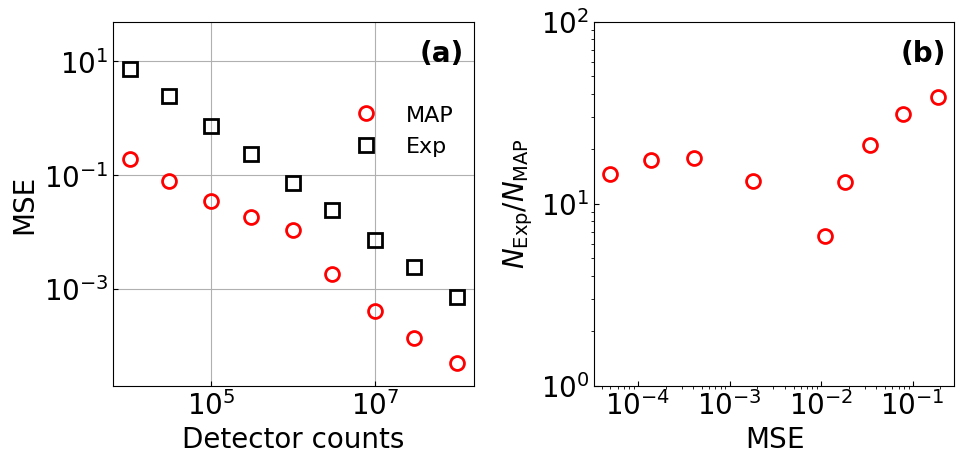

In [8]:
panel_list = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)

ax.plot(n_sample_list, mse_list, 'o', color='r', label='MAP',  fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(n_sample_list, mse_sparse_list, 's', color='k', label='Exp',  fillstyle='none', ms=10, markeredgewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid('on')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-5, 5e1])
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.text(0.85, 0.95, panel_list[0], transform=ax.transAxes,
       fontsize=20, verticalalignment='top', color='k', fontweight='bold')

ax.legend(fontsize=16, frameon=False, loc='right', bbox_to_anchor=(1, 0.7))

ax = plt.subplot(1, 2, 2)
# Convert to log scale
log_n = np.log(n_sample_list)
log_mse = np.log(mse_sparse_list)

# Fit a linear model: log_mse = log_A - B * log_n
coeffs = np.polyfit(log_n, log_mse, 1)
B = -coeffs[0]
log_A = coeffs[1]
A = np.exp(log_A)

# Define the inverse function: given mse, return n_sample
def estimate_n_sample_from_mse(mse):
    return (mse / A) ** (-1 / B)

n_map_list = estimate_n_sample_from_mse(mse_list)
ratio_n_list = np.array(n_map_list) / np.array(n_sample_list)

ax.plot(mse_list, ratio_n_list, 'o', color='r', label='MAP',  fillstyle='none', ms=10, markeredgewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1,100])
ax.set_xlabel(r'$\mathrm{MSE}}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{Exp}/N_\mathrm{MAP}$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
ax.text(0.85, 0.95, panel_list[1], transform=ax.transAxes,
       fontsize=20, verticalalignment='top', color='k', fontweight='bold')

plt.tight_layout(pad=2)